<a href="https://colab.research.google.com/github/danikagupta/DeepTextile/blob/main/NIRS_outliertesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


/usr/local/lib/python3.12/dist-packages/spectral/io/envi.py:187: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


Raw cube: (2080, 640, 214) | Bands: 214


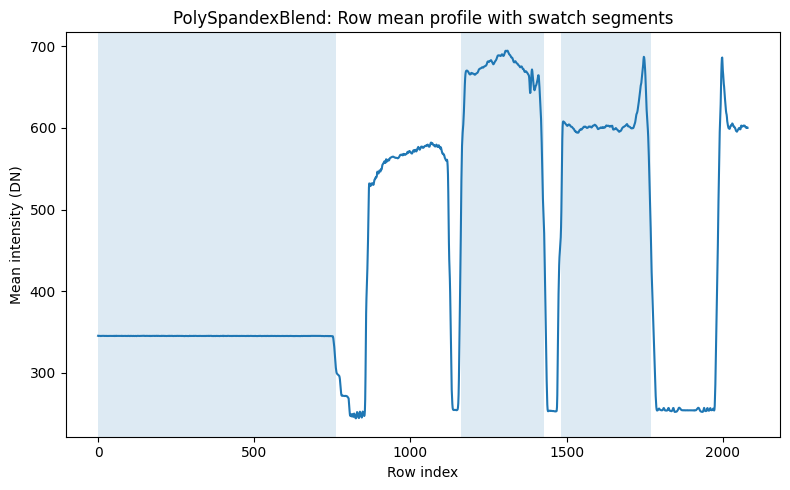

/tmp/ipython-input-2349867402.py:90: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  Rc = (S_cube - Dv) / (Wv - Dv + eps)


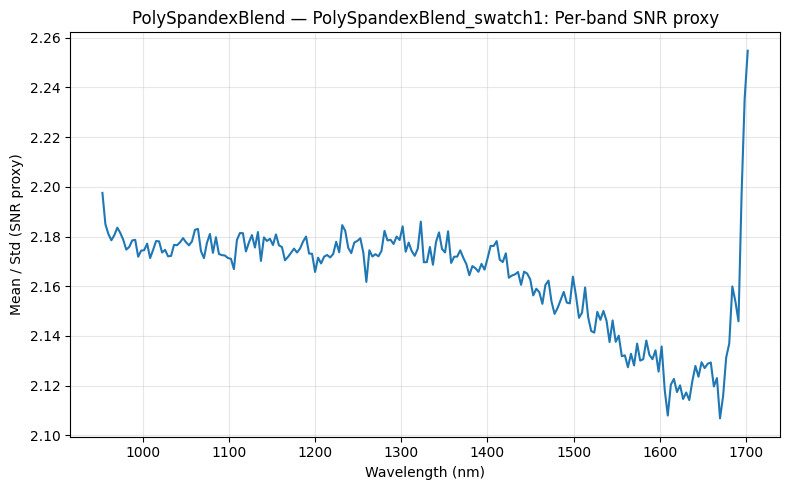

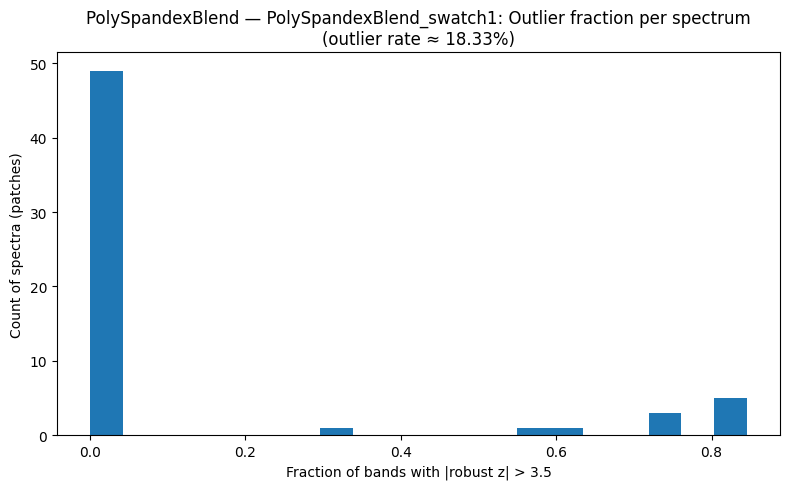

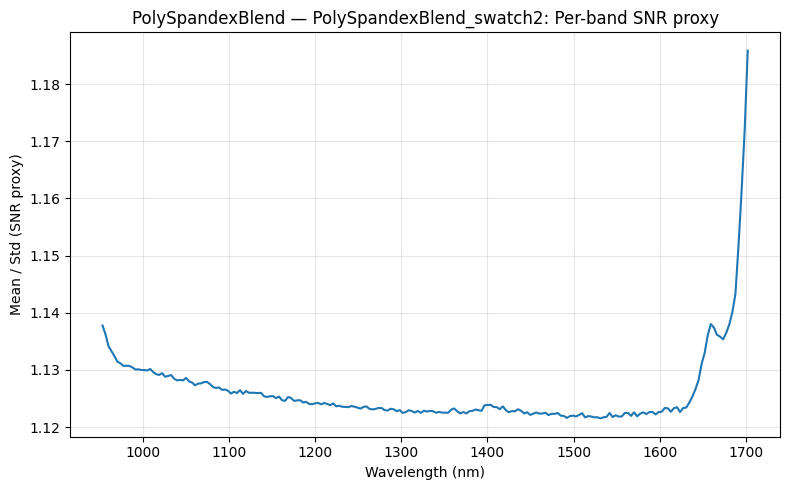

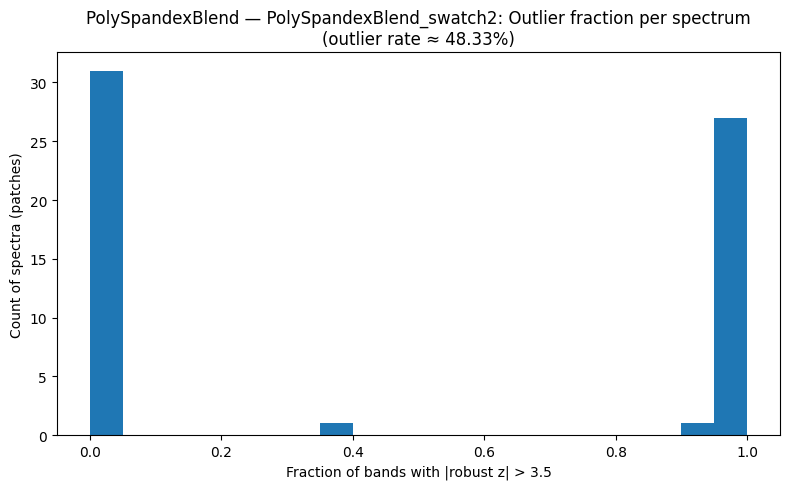

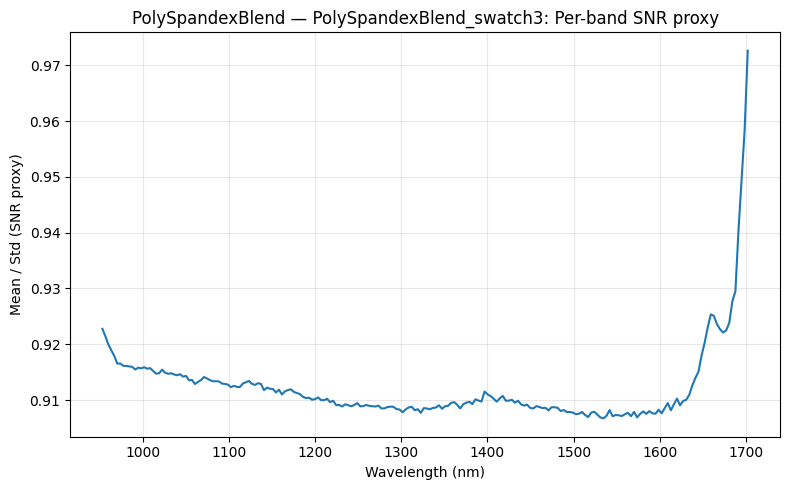

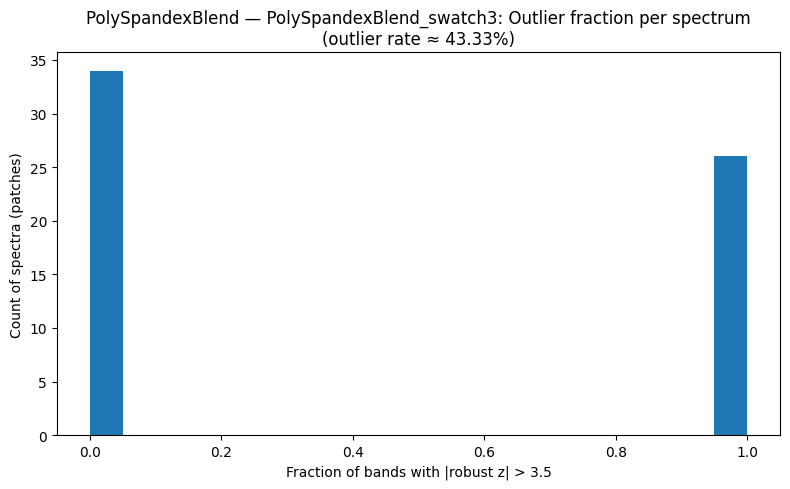

Saved spectra CSV: /content/drive/Shareddrives/Danika-work4/Textile/outlierPolySpandexBlend/polyspandexblend_patch_spectra_sampled.csv
Saved SNR summary CSV: /content/drive/Shareddrives/Danika-work4/Textile/outlierPolySpandexBlend/polyspandexblend_snr_summary.csv
Saved outlier summary CSV: /content/drive/Shareddrives/Danika-work4/Textile/outlierPolySpandexBlend/polyspandexblend_outlier_summary.csv
All figures and CSVs in: /content/drive/Shareddrives/Danika-work4/Textile/outlierPolySpandexBlend


In [11]:
# =============================
# Colab: Noise & Outlier Analysis (per cube) — swatch-aware
# =============================
# This cell:
#  - loads one ENVI cube with WHITEREF/DARKREF
#  - segments into 3 swatches (row-wise or column-wise)
#  - calibrates to reflectance
#  - samples many random patches per swatch
#  - computes per-band SNR proxy (mean/SD) per swatch and overall
#  - detects spectral outliers using robust z-scores (median/MAD)
#  - saves figures (SNR curves, outlier hist) and CSV summaries
#
# Edit the "EDIT THESE" block for your file paths and settings.

!pip -q install spectral numpy matplotlib pandas scikit-learn

import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import spectral as spy
from sklearn.cluster import KMeans

plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['savefig.dpi'] = 300

# ---------- EDIT THESE ----------
CLASS_NAME        = "PolySpandexBlend"  # Used in filenames/captions
OUTDIR            = ""

# ENVI HDR paths for this cube (sample + references)
SAMPLE_HDR        = ""
WHITEREF_HDR      = ""
DARKREF_HDR       = ""

# Swatch layout in the cube: 'row' (stacked vertically) or 'col' (side-by-side)
LAYOUT_AXIS       = "row"

# Bands to trim (to remove high-noise edges); set to None to disable
TRIM_BANDS        = (5, -5)

# Patch sampling
PATCH_SIZE_RC     = (20, 20)      # (rows, cols) per patch
PATCHES_PER_SWATCH= 60            # total random patches to sample per swatch
RANDOM_SEED       = 123

# Outlier detection thresholds
# robust z per band using median/MAD across patches in a swatch
ABS_Z_BAND_THRESH = 3.5           # band-level |z| beyond this is "extreme"
FRACTION_BANDS_EXTREME = 0.08     # if >6% of bands are extreme → mark spectrum outlier
# ---------- END EDIT ----------

os.makedirs(OUTDIR, exist_ok=True)
rng = np.random.default_rng(RANDOM_SEED)

# ---------- Helpers ----------
def open_envi(hdr_path):
    img = spy.open_image(hdr_path)
    cube = img.load()
    if cube.ndim != 3:
        raise ValueError(f"Expected 3D cube, got {cube.shape} @ {hdr_path}")
    return img, cube

def wavelengths_from_hdr(img):
    if hasattr(img, 'bands') and hasattr(img.bands, 'centers'):
        try:
            wl = np.array(img.bands.centers, dtype=float)
            return wl
        except Exception:
            pass
    return None

def apply_trim(arr, trim):
    if trim is None:
        return arr
    s, e = trim
    if isinstance(arr, np.ndarray):
        if arr.ndim == 1:
            return arr[s: (None if e == 0 else e)]
        else:
            return arr[..., s: (None if e == 0 else e)]
    return arr

def ref_vector_from_cube(ref_cube):
    return np.asarray(ref_cube.mean(axis=(0,1)))

def calibrate_cube(S_cube, W_vec, D_vec, eps=1e-6):
    Wv = W_vec.reshape((1,1,-1))
    Dv = D_vec.reshape((1,1,-1))
    Rc = (S_cube - Dv) / (Wv - Dv + eps)
    return np.clip(Rc, 0.0, 1.0)

def qc_rowcol_means(S_cube, axis='row'):
    if axis == 'row':
        return S_cube.mean(axis=(1,2))
    else:
        return S_cube.mean(axis=(0,2))

def contiguous_segments(labels):
    segs = []
    start = 0
    cur = labels[0]
    for i in range(1, len(labels)):
        if labels[i] != cur:
            segs.append((start, i, cur))
            start = i
            cur = labels[i]
    segs.append((start, len(labels), cur))
    return segs

def kmeans_segment_1d(signal_1d, n_segments=3):
    X = signal_1d.reshape(-1,1)
    km = KMeans(n_clusters=n_segments, n_init=10, random_state=0)
    lab = km.fit_predict(X)
    runs = contiguous_segments(lab)
    runs_sorted = sorted(runs, key=lambda t: (t[1]-t[0]), reverse=True)[:n_segments]
    runs_sorted = sorted(runs_sorted, key=lambda t: t[0])
    return runs_sorted

def choose_random_patch_within_slice(swatch_slice_rc, cube_shape, patch_size_rc, rng):
    r_slice, c_slice = swatch_slice_rc
    r0_min = r_slice.start
    r0_max = r_slice.stop - patch_size_rc[0]
    c0_min = c_slice.start
    c0_max = c_slice.stop - patch_size_rc[1]
    if r0_max <= r0_min or c0_max <= c0_min:
        raise ValueError("Patch size too large for the swatch slice; adjust PATCH_SIZE_RC or segmentation.")
    r0 = rng.integers(r0_min, r0_max+1)
    c0 = rng.integers(c0_min, c0_max+1)
    return (slice(r0, r0+patch_size_rc[0]), slice(c0, c0+patch_size_rc[1]))

def extract_patch_spectrum(cube, patch_slice):
    sub = cube[patch_slice[0], patch_slice[1], :]
    return np.asarray(sub.mean(axis=(0,1)))

# ---------- Load & prepare ----------
S_img, S_cube_raw = open_envi(SAMPLE_HDR)
W_img, W_cube = open_envi(WHITEREF_HDR)
D_img, D_cube = open_envi(DARKREF_HDR)

W_vec = ref_vector_from_cube(W_cube)
D_vec = ref_vector_from_cube(D_cube)

# Apply band trimming
S_cube_raw = apply_trim(S_cube_raw, TRIM_BANDS)
W_vec      = apply_trim(W_vec, TRIM_BANDS)
D_vec      = apply_trim(D_vec, TRIM_BANDS)

wavelengths = wavelengths_from_hdr(S_img)
if wavelengths is not None:
    wavelengths = apply_trim(wavelengths, TRIM_BANDS)

bands = S_cube_raw.shape[2]
rows, cols = S_cube_raw.shape[0], S_cube_raw.shape[1]
x = wavelengths if wavelengths is not None else np.arange(bands)
x_label = "Wavelength (nm)" if wavelengths is not None else "Band index"

print("Raw cube:", S_cube_raw.shape, "| Bands:", bands)

# Segment into swatches
if LAYOUT_AXIS == "row":
    prof = qc_rowcol_means(S_cube_raw, axis='row')
    runs = kmeans_segment_1d(prof, n_segments=3)
    swatch_slices = [(slice(r0, r1), slice(0, cols)) for (r0, r1, _) in runs]
else:
    prof = qc_rowcol_means(S_cube_raw, axis='col')
    runs = kmeans_segment_1d(prof, n_segments=3)
    swatch_slices = [(slice(0, rows), slice(c0, c1)) for (c0, c1, _) in runs]

# Save profile with segments
plt.figure()
plt.plot(prof)
for (a,b,_) in runs:
    plt.axvspan(a, b, alpha=0.15)
plt.title(f"{CLASS_NAME}: {'Row' if LAYOUT_AXIS=='row' else 'Col'} mean profile with swatch segments")
plt.xlabel("Row index" if LAYOUT_AXIS=='row' else "Col index")
plt.ylabel("Mean intensity (DN)")
plt.tight_layout()
seg_profile_path = os.path.join(OUTDIR, f"{CLASS_NAME.lower()}_seg_profile.png")
plt.savefig(seg_profile_path)
plt.show()

# Calibrate full cube
R_cube = calibrate_cube(S_cube_raw, W_vec, D_vec, eps=1e-6)

# Sample patches per swatch and build spectra matrix
records = []
for sidx, sw_slice in enumerate(swatch_slices, start=1):
    for k in range(PATCHES_PER_SWATCH):
        patch_slice = choose_random_patch_within_slice(sw_slice, R_cube.shape, PATCH_SIZE_RC, rng)
        spec = extract_patch_spectrum(R_cube, patch_slice)  # (bands,)
        records.append({
            "class": CLASS_NAME,
            "swatch": f"{CLASS_NAME}_swatch{sidx}",
            "r0": patch_slice[0].start, "r1": patch_slice[0].stop,
            "c0": patch_slice[1].start, "c1": patch_slice[1].stop,
            **{f"b{i}": float(spec[i]) for i in range(bands)}
        })

spec_df = pd.DataFrame.from_records(records)
csv_specs = os.path.join(OUTDIR, f"{CLASS_NAME.lower()}_patch_spectra_sampled.csv")
spec_df.to_csv(csv_specs, index=False)

# ---------- SNR & Outliers ----------
snr_rows = []
outlier_rows = []

for swatch, sdf in spec_df.groupby("swatch"):
    M = sdf[[f"b{i}" for i in range(bands)]].values
    per_band_mean = M.mean(axis=0)
    per_band_std  = M.std(axis=0, ddof=0)
    snr = np.where(per_band_std > 0, per_band_mean / per_band_std, np.nan)

    # SNR figure
    plt.figure()
    plt.plot(x, snr)
    plt.xlabel(x_label); plt.ylabel("Mean / Std (SNR proxy)")
    plt.title(f"{CLASS_NAME} — {swatch}: Per-band SNR proxy")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    pth = os.path.join(OUTDIR, f"{swatch}_snr_proxy.png")
    plt.savefig(pth)
    plt.show()

    snr_rows.append({
        "class": CLASS_NAME, "swatch": swatch,
        "bands": bands,
        "snr_mean": float(np.nanmean(snr)),
        "snr_median": float(np.nanmedian(snr)),
        "snr_min": float(np.nanmin(snr)),
        "snr_max": float(np.nanmax(snr))
    })

    # Robust z per band within swatch (median/MAD)
    med = np.median(M, axis=0)
    mad = np.median(np.abs(M - med), axis=0)
    denom = (mad * 1.4826) + 1e-12
    RZ = (M - med) / denom
    frac_extreme = (np.abs(RZ) > ABS_Z_BAND_THRESH).mean(axis=1)

    out_mask = frac_extreme > FRACTION_BANDS_EXTREME
    out_count = int(out_mask.sum())
    total = M.shape[0]
    outlier_rate = out_count / total if total else 0.0

    outlier_rows.append({
        "class": CLASS_NAME, "swatch": swatch,
        "patches": total, "outliers": out_count,
        "outlier_rate": outlier_rate,
        "abs_z_thresh": ABS_Z_BAND_THRESH,
        "frac_bands_thresh": FRACTION_BANDS_EXTREME
    })

    # Histogram of outlier fraction
    plt.figure()
    plt.hist(frac_extreme, bins=20)
    plt.xlabel("Fraction of bands with |robust z| > {:.1f}".format(ABS_Z_BAND_THRESH))
    plt.ylabel("Count of spectra (patches)")
    plt.title(f"{CLASS_NAME} — {swatch}: Outlier fraction per spectrum\n(outlier rate ≈ {outlier_rate:.2%})")
    plt.tight_layout()
    pth = os.path.join(OUTDIR, f"{swatch}_outlier_fraction_hist.png")
    plt.savefig(pth)
    plt.show()

# Save summaries
snr_df = pd.DataFrame(snr_rows)
out_df = pd.DataFrame(outlier_rows)
snr_csv = os.path.join(OUTDIR, f"{CLASS_NAME.lower()}_snr_summary.csv")
out_csv = os.path.join(OUTDIR, f"{CLASS_NAME.lower()}_outlier_summary.csv")
snr_df.to_csv(snr_csv, index=False)
out_df.to_csv(out_csv, index=False)

print("Saved spectra CSV:", csv_specs)
print("Saved SNR summary CSV:", snr_csv)
print("Saved outlier summary CSV:", out_csv)
print("All figures and CSVs in:", OUTDIR)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')